# Imports

In [ ]:
## utils
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.io import loadmat
import glob
import os
from PIL import Image
import seaborn as sns
import shutil
from tqdm import tqdm
import pickle
from statistics import mode
from collections import defaultdict
import gc

## tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16

## sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split



# Mount Google Drive

## Dataset Access (Private)

The original handwriting images are proprietary and stored in a private Google Drive.
They are **not** included in this repository.

To reproduce the experiments:
1. Obtain access credentials from the dataset owers.
2. Mount your Google Drive in Colab:
  ```python
  from google.colab import drive
  drive.mount('/content/drive')
  ```
3. Set an environment variable pointing to the project folder:
  ```python
  data_path = 'drive/MyDrive/DL_PROJECT'
  ```

In [ ]:
# Define folders to be created and used

orig_images = "images" # storing original images
authors_dir = 'authors' # storing the author's .pkl files
base_dir = 'dataset_directory' # storing the data sets (after pre-processing)
train_dir = os.path.join(base_dir, 'train') # train data set directory
val_dir = os.path.join(base_dir, 'validation') # validation data set directory
test_dir = os.path.join(base_dir, 'test') # test data set directory

In [ ]:
# If already exist, recursively delete and re-create

for dir_path in [train_dir, val_dir, test_dir, orig_images, authors_dir]:
  if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
  os.makedirs(dir_path)

In [ ]:
author_images_dir = f'{data_path}/author_images' # where the images are kept inside the Google Drive project folder

In [ ]:
author_mat_dir = f'{data_path}/author_mat' # where the .mat files are kept inside the Google Drive project folder

# Read the files

In [ ]:
# List of all the files names

author_images = glob.glob(author_images_dir + '/*.jpg')

In [ ]:
# get only the file name without the extension

author_names = [os.path.splitext(os.path.basename(filename))[0]
                for filename in author_images]

# Define Consts

In [ ]:
MAX_HEIGHT = 0

In [ ]:
MAX_WIDTH = 600

# Functions for Segment Generator

In [ ]:
def ensure_file_exists(filepath: str):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"The file {filepath} does not exist!")

In [ ]:
def load_image(image_path: str):
    ensure_file_exists(image_path)
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to read the image from {image_path}")
    return image

In [ ]:
def convert_to_grayscale(img):
  if img.ndim == 3 and img.shape[2] == 3:  # Verificar si la imagen es BGR
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else:
      gray = img  # La imagen ya está en escala de grises
  return gray

In [ ]:
def get_white_pixel_ratio(img, threshold=245):

    gray = convert_to_grayscale(img)

    total_pixels = gray.size
    white_pixels = np.sum(gray >= threshold)
    return white_pixels / total_pixels

In [ ]:
def segment_image(image, top_area, bottom_area):
  img = image[top_area : bottom_area]
  return img

In [ ]:
def getEpsilon(lines_y: list, top_test_area: int, bottom_test_area: int):

    start_index = np.searchsorted(lines_y, top_test_area, side='right')
    end_index = np.searchsorted(lines_y, bottom_test_area, side='left')

    min = np.min(np.array([top_test_area - lines_y[start_index - 1],
                           bottom_test_area - lines_y[end_index - 1]]))

    max = np.max(np.array([top_test_area - lines_y[start_index - 1],
                           bottom_test_area - lines_y[end_index - 1]]))

    return min, max

In [ ]:
def contains_only_horizontal_line(segment):

    img = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    horizontal_contours = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > h:
            horizontal_contours += 1

    return horizontal_contours

In [ ]:
def pad_segment(segment, new_height):
    height, width = segment.shape[:2]

    if new_height <= height:
      return segment

    total_padding = new_height - height
    top_padding = total_padding // 2
    bottom_padding = total_padding - top_padding

    if len(segment.shape) == 2:
      top = np.full((top_padding, width), 255, dtype=np.uint8)
      bottom = np.full((bottom_padding, width), 255, dtype=np.uint8)
    else:
      top = np.full((top_padding, width, 3), 255, dtype=np.uint8)
      bottom = np.full((bottom_padding, width, 3), 255, dtype=np.uint8)

    padded_segment = np.vstack((top, segment, bottom))
    return padded_segment

In [ ]:
def get_white_pixel_ratio(segment, max_mean=245):
    white_pixels = np.sum(segment > max_mean)
    total_pixels = segment.size
    return white_pixels / total_pixels

In [ ]:
def split_and_normalize(segment, max_mean, threshold):

  height, width = segment.shape[:2]
  num_subsegments = width // MAX_WIDTH

  subsegments = []
  for i in range(num_subsegments):
    subsegment = segment[:, i * MAX_WIDTH : (i + 1) * MAX_WIDTH]
    if not contains_only_horizontal_line(subsegment) == 1:
      white_ratio = round(get_white_pixel_ratio(subsegment, max_mean=max_mean), 3)
      if white_ratio < threshold:
        subsegments.append(pad_segment(subsegment, 180))

  subsegments.reverse()

  return subsegments

In [ ]:
def display_image(img, title=""):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
def preprocess_image(image):
    # Convert to grayscale if the image has three dimensions (indicating channels)
    if image.ndim == 3 and image.shape[2] == 3:
        grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        grayscale = image

    # Binarization without inversion
    _, binarized = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Noise reduction using morphological operations
    kernel = np.ones((2, 2), np.uint8)
    opened = cv2.morphologyEx(binarized, cv2.MORPH_OPEN, kernel)

    # Blurring
    blurred = cv2.GaussianBlur(opened, (81, 1501), 0)

    return blurred


In [ ]:
def remove_wide_whitespace(segment, threshold=0.97, max_space_width=30):
    """
    Remove whitespace that exceeds a certain width.

    Args:
    - segment (numpy array): The image segment containing the line.
    - threshold (float): The threshold to identify whitespace columns.
    - max_space_width (int): Width above which a whitespace is removed.

    Returns:
    - numpy array: The segment with wide whitespace removed.
    """

    preprocessed_segment = preprocess_image(segment)


    # Get the sum of the pixel values for each column
    column_sums = np.sum(preprocessed_segment, axis=0)

    # Identify potential spaces based on a threshold and ensure it's a 1D boolean array
    space_flags = (column_sums > threshold * np.max(column_sums)).flatten()

    # Convert boolean array to list of start and end positions for spaces
    in_space = False
    spaces = []
    for i, flag in enumerate(space_flags):
        if flag and not in_space:
            start = i
            in_space = True
        elif not flag and in_space:
            end = i
            if (end - start) > max_space_width:
                spaces.append((start, end))
            in_space = False

    # Add this section to handle trailing whitespace
    if in_space and (i - start) > max_space_width:
        spaces.append((start, i))

    # Filter out columns that are in the identified wide spaces
    new_cols = []
    for i in range(len(space_flags)):
        if not any(start <= i < end for start, end in spaces):
            new_cols.append(segment[:, i:i+1])


    # Construct the new segment
    new_segment = np.hstack(new_cols)

    # Calculate padding required to make the width of new_segment same as original segment
    left_padding = segment.shape[1] - new_segment.shape[1]

    # Add padding only on the left side to make it the same width as the original
    new_segment = cv2.copyMakeBorder(new_segment, 0, 0, left_padding, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])


    return new_segment

# Segment Generator Class

This class will handle the data and logic for handling the data (authors images, mat files, etc) and will be saved to .pkl file once done

In [ ]:
class SegmentGenerator:
  def __init__(self, author: str):
    self._author = author
    self._getLinesAndTopAndBottom()
    self._process_image()


  def _getLinesAndTopAndBottom(self):
    mat_path = f'{author_mat_dir}/{self._author}.mat'
    ensure_file_exists(mat_path)

    stam = loadmat(mat_path)
    self._peaks_indices = stam['peaks_indices'].flatten()
    self._index_of_max_in_peak_indices = stam['index_of_max_in_peak_indices'].flatten()[0]
    self._SCALE_FACTOR = stam['SCALE_FACTOR'].flatten()[0]
    self._delta = stam['delta'].flatten()[0]
    self._top_test_area = stam['top_test_area'].flatten()[0]
    self._bottom_test_area = stam['bottom_test_area'].flatten()[0]
    self._generate_lines_y()

  def _process_image(self):
    image = load_image(f'{data_path}/author_images/{self._author}.jpg').copy()

    cv2.imwrite(f'./{orig_images}/copy_{self._author}.jpg', image)


  @property
  def author(self):
    return self._author

  @property
  def top_test_area(self):
    return self._top_test_area

  @property
  def bottom_test_area(self):
    return self._bottom_test_area

  @property
  def lines_y(self):
    if not hasattr(self, '_lines_y'):
      self._generate_lines_y()
    return self._lines_y

  @property
  def non_empty_segments(self):
    if not hasattr(self, '_non_empty_segments'):
      self._divide_segments()
    return self._non_empty_segments

  @property
  def forbidden_image_segments(self):
    if not hasattr(self, '_forbidden_segment_image'):
      self._load_forbidden_segment()
    self._divide_forbidden()
    return self._forbidden_image_segments

  def _load_forbidden_segment(self):
    image = load_image(f'{data_path}/author_images/{self._author}.jpg')
    self._forbidden_segment_image = segment_image(image, self._top_test_area, self._bottom_test_area)


  @property
  def forbidden_image(self):
    if not hasattr(self, '_forbidden_segment_image'):
      self._load_forbidden_segment()
    self._forbidden_image = self._forbidden_segment_image
    return self._forbidden_image

  @property
  def img_top(self):
    if not hasattr(self, '_img_top'):
      self._divide_segments()
    return self._img_top

  @property
  def img_bottom(self):
    if not hasattr(self, '_img_bottom'):
      self._divide_segments()
    return self._img_bottom


  def _generate_lines_y(self):
    self._lines_y = np.array(self._peaks_indices) * self._SCALE_FACTOR

  def _search_max_dimension(self):
    height, width, _ = self.forbidden_image.shape[:3]

    self._max_dimension = {
        'height': height,
        'width': width
    }

  @property
  def max_dimension(self):
    if not hasattr(self, '_max_dimension'):
      self._search_max_dimension()
    return self._max_dimension

  def _divide_forbidden(self):
    self._forbidden_image_segments = []
    threshold = 0.98
    max_mean = 241
    reduced_whitespace_segment = remove_wide_whitespace(self._forbidden_segment_image)
    segments = split_and_normalize(reduced_whitespace_segment, max_mean, threshold)
    return self._forbidden_image_segments.extend(segments)

  def _divide_segments(self):
    self._non_empty_segments = []
    image = load_image(f'./{orig_images}/copy_{self._author}.jpg')
    threshold = 0.98
    max_mean = 241

    heights = np.diff(self._lines_y)
    mean_heights = np.mean(heights) * 0.6

    min, max = getEpsilon(self._lines_y, self._top_test_area, self._bottom_test_area)

    for i in range(len(self._lines_y) - 1):
        start_y = self._lines_y[i]
        end_y = self._lines_y[i + 1]

        start_y = self._bottom_test_area if start_y <= self._bottom_test_area and end_y >= self._bottom_test_area else start_y + min

        end_y = self._top_test_area if start_y <= self._top_test_area and end_y >= self._top_test_area else end_y + max

        if (end_y - start_y) >= mean_heights:
            segment = image[start_y:end_y, :]

            # Reduce the white spaces between words inside the line
            reduced_whitespace_segment = remove_wide_whitespace(segment)

            if not contains_only_horizontal_line(reduced_whitespace_segment) == 1:
                white_ratio = round(get_white_pixel_ratio(reduced_whitespace_segment, max_mean=max_mean), 3)
                if white_ratio < threshold:
                    segments = split_and_normalize(reduced_whitespace_segment, max_mean, threshold)
                    self._non_empty_segments.extend(segments)

In [ ]:
def save_segments_to_directory(segments, author, base_directory):
    author_dir = os.path.join(base_directory, author)

    if not os.path.exists(author_dir):
        os.makedirs(author_dir)

    for i, segment in enumerate(segments):
        segment_image_path = os.path.join(author_dir, f'{author}_{i}.jpg')
        Image.fromarray(segment).save(segment_image_path)

# Utils functions for displaying statistics and data

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
def dplot_smoothing(accuracy, val_accuracy, loss, val_loss, epochs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    X = range(1, epochs + 1)

    ax1.plot(X, smooth_curve(accuracy), 'bo', label='Smoothed training acc')
    ax1.plot(X, smooth_curve(val_accuracy), 'b', label='Smoothed validation acc')
    ax1.title.set_text('Training and validation accuracy')
    ax1.legend()

    ax2.plot(X, smooth_curve(loss), 'bo', label='Smoothed training loss')
    ax2.plot(X, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
    ax2.title.set_text('Training and validation loss')
    ax2.legend()

    fig.tight_layout()
    plt.show()

In [ ]:
def dplot_graph(accuracy, val_accuracy, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    epochs = range(1, len(accuracy) + 1)

    ax1.plot(epochs, loss, 'bo', label='Training Loss')
    ax1.plot(epochs, val_loss, 'b', label='Validation Loss')
    ax1.title.set_text('Loss Model')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    ax2.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    ax2.title.set_text('Accuracy Model')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    fig.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
def dplot_confusion_matrix(model, val_data_gen, test_data_gen):

  y_val_pred_probs = model.predict(val_data_gen)
  y_val_preds = np.argmax(y_val_pred_probs, axis=1)
  y_val_true = val_data_gen.classes

  y_test_pred_probs = model.predict(test_data_gen)
  y_test_preds = np.argmax(y_test_pred_probs, axis=1)
  y_test_true = test_data_gen.classes

  conf_matrix_val = confusion_matrix(y_val_true, y_val_preds)
  conf_matrix_test = confusion_matrix(y_test_true, y_test_preds)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  cax1 = ax1.matshow(conf_matrix_val, cmap=plt.cm.Blues)
  fig.colorbar(cax1, ax=ax1)
  ax1.set_title('Validation Confusion Matrix', pad=20)
  ax1.set_xlabel('Predicted')
  ax1.set_ylabel('True')

  cax2 = ax2.matshow(conf_matrix_test, cmap=plt.cm.Blues)
  fig.colorbar(cax2, ax=ax2)
  ax2.set_title('Test Confusion Matrix', pad=20)
  ax2.set_xlabel('Predicted')
  ax2.set_ylabel('True')

  plt.tight_layout()
  plt.show()

# Model utils

In [ ]:
def build_transfer_model(input_shape, num_classes=10):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))

    model = models.Sequential()

    # Add a lambda layer to replicate grayscale channel to RGB
    model.add(layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1), input_shape=input_shape))

    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    for layer in base_model.layers:
        layer.trainable = False

    return model

In [ ]:
def majority_vote(predictions):
    return mode(predictions)

In [ ]:
def categorize_predictions(author_to_final_preds, index_to_class):
    correct_predictions = {}
    incorrect_predictions = {}

    for author, pred_idx in author_to_final_preds.items():
        predicted_author = index_to_class[pred_idx]
        if predicted_author == author:
            correct_predictions[author] = pred_idx
        else:
            incorrect_predictions[author] = pred_idx

    return correct_predictions, incorrect_predictions

In [ ]:
def predict_using_majority_vote_by_author(model, test_data_gen):
    predictions = model.predict(test_data_gen)
    predicted_labels = np.argmax(predictions, axis=1)

    author_to_predictions = defaultdict(list)

    for filename, label in zip(test_data_gen.filenames, predicted_labels):
        author_name = os.path.dirname(filename)
        author_to_predictions[author_name].append(label)

    author_to_final_prediction = {}
    author_to_confidence = {}
    for author, preds in author_to_predictions.items():
        most_common_pred = majority_vote(preds)
        confidence = preds.count(most_common_pred) / len(preds)

        author_to_final_prediction[author] = most_common_pred
        author_to_confidence[author] = confidence

    return author_to_final_prediction, author_to_confidence

In [ ]:
def display_mispredictions(author, predicted_author, directory):

    author_dir = os.path.join(directory, f"{author}.pkl")
    with open(author_dir, "rb") as file:
        author_obj = pickle.load(file)
        author_image = author_obj.forbidden_image

    predicted_dir = os.path.join(directory, f"{predicted_author}.pkl")
    with open(predicted_dir, "rb") as file:
        predicted_obj = pickle.load(file)
        predicted_image = predicted_obj.forbidden_image

    fig, ax = plt.subplots(2, 1)

    ax[0].imshow(author_image, cmap='gray')
    ax[0].title.set_text(f"Test: {author}")

    ax[1].imshow(predicted_image, cmap='gray')
    ax[1].title.set_text(f"Predicted: {predicted_author}")

In [ ]:
def display_images_and_predictions(author_dir, pred_idx, confidence, index_to_class):
    with open(author_dir, 'rb') as file:
      loaded_author = pickle.load(file)

    image = loaded_author.original_test_image

    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Author: {index_to_class[pred_idx]} with {confidence*100:.2f}% confidence")
    plt.show()

# Create the data sets using Segment Generators

#### Select part of the authors

In [ ]:
# select what percentage from the 407 authors we want to use
fraction_of_authors = 0.5

In [ ]:
selected_authors = author_names[:int(len(author_names) * fraction_of_authors)]

In [ ]:
print(len(selected_authors))

203

#### create a Segment Generator for each author

In [ ]:
pbar = tqdm(selected_authors, desc='Processing authors', ncols=100)

for author in pbar:
    pbar.set_postfix(current_author=author)
    cur_author = SegmentGenerator(author)

    height = cur_author.max_dimension.get('height')
    if height > MAX_HEIGHT: MAX_HEIGHT = height

    file_path = os.path.join(authors_dir, f"{author}.pkl")
    with open(file_path, 'wb') as file:
        pickle.dump(cur_author, file)

    del cur_author
    gc.collect()

pbar.close()

Processing authors: 100%|██████████| 203/203 [04:55<00:00,  1.46s/it, current_author=lines4_Page_06]


#### Segment the hand-written lines of each writer to small segments and split to train, val and test

In [ ]:
pbar = tqdm(selected_authors, desc='Processing authors', ncols=100)

for author in pbar:
  pbar.set_postfix(current_author=author)
  file_path = os.path.join(authors_dir, f"{author}.pkl")
  with open(file_path, 'rb') as file:
    loaded_author = pickle.load(file)

    author = loaded_author.author
    non_empty_images = loaded_author.non_empty_segments
    forbidden_images = loaded_author.forbidden_image_segments

    train, val = train_test_split(non_empty_images, test_size=0.2, random_state=42)

    save_segments_to_directory(forbidden_images, author, test_dir)
    save_segments_to_directory(train, author, train_dir)
    save_segments_to_directory(val, author, val_dir)

pbar.close()

Processing authors: 100%|██████████| 203/203 [10:01<00:00,  2.96s/it, current_author=lines4_Page_06]


# Model build and configure

#### Build the transfer model

In [ ]:
if 'model' in globals():
    del model

model = build_transfer_model((MAX_HEIGHT, MAX_WIDTH, 1), num_classes=len(selected_authors))

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 220, 600, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 6, 18, 512)        14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 203)               52171     
                                                                 
Total params: 14898187 (56.83 MB)
Trainable params: 18349

#### Define Optimizer

In [ ]:
opt = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Define callbacks

In [ ]:
eraly_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001, min_lr=0.00001)

# Create the Image Data Generators for training, validation and testing

In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)


test_datagen = image.ImageDataGenerator(rescale=1./255)

In [ ]:
# define batch size
batch_size=8

In [ ]:
train_data_gen = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=batch_size,
                                                   target_size=(MAX_HEIGHT, MAX_WIDTH),
                                                   class_mode='categorical',
                                                   color_mode='grayscale')

Found 10712 images belonging to 203 classes.


In [ ]:
val_data_gen = test_datagen.flow_from_directory(val_dir,
                                                batch_size=batch_size,
                                                target_size=(MAX_HEIGHT, MAX_WIDTH),
                                                shuffle=False,
                                                class_mode='categorical',
                                                color_mode='grayscale')

Found 2779 images belonging to 203 classes.


In [ ]:
test_data_gen = test_datagen.flow_from_directory(test_dir,
                                                 batch_size=batch_size,
                                                 target_size=(MAX_HEIGHT, MAX_WIDTH),
                                                 class_mode='categorical',
                                                 shuffle=False,
                                                 color_mode='grayscale')

Found 962 images belonging to 203 classes.


# Train the model

#### calculate epochs and steps

In [ ]:
steps_per_epoch = train_data_gen.samples // train_data_gen.batch_size

In [ ]:
steps_per_epoch

1339

In [ ]:
validation_steps = val_data_gen.samples // val_data_gen.batch_size

In [ ]:
validation_steps

347

#### Train the model

In [ ]:
history = model.fit(
    train_data_gen,
    epochs=len(selected_authors),
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, eraly_stop, reduce_lr]
)

Epoch 1/203
1339/1339 [==============================] - ETA: 0s - loss: 5.0649 - accuracy: 0.0200
Epoch 1: val_accuracy improved from -inf to 0.04575, saving model to best_model.h5
1339/1339 [==============================] - 214s 150ms/step - loss: 5.0649 - accuracy: 0.0200 - val_loss: 4.6630 - val_accuracy: 0.0457 - lr: 0.0010
Epoch 2/203


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1339/1339 [==============================] - ETA: 0s - loss: 4.3974 - accuracy: 0.0583
Epoch 2: val_accuracy improved from 0.04575 to 0.07097, saving model to best_model.h5
1339/1339 [==============================] - 205s 153ms/step - loss: 4.3974 - accuracy: 0.0583 - val_loss: 4.1918 - val_accuracy: 0.0710 - lr: 0.0010
Epoch 3/203
1339/1339 [==============================] - ETA: 0s - loss: 4.0389 - accuracy: 0.0966
Epoch 3: val_accuracy improved from 0.07097 to 0.10663, saving model to best_model.h5
1339/1339 [==============================] - 205s 153ms/step - loss: 4.0389 - accuracy: 0.0966 - val_loss: 3.9593 - val_accuracy: 0.1066 - lr: 0.0010
Epoch 4/203
1339/1339 [==============================] - ETA: 0s - loss: 3.7726 - accuracy: 0.1325
Epoch 4: val_accuracy improved from 0.10663 to 0.12392, saving model to best_model.h5
1339/1339 [==============================] - 205s 153ms/step - loss: 3.7726 - accuracy: 0.1325 - val_loss: 3.7676 - val_accuracy: 0.1239 - lr: 0.0010
Epoch 5

# Model statistics

In [ ]:
selected_history = {
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
}

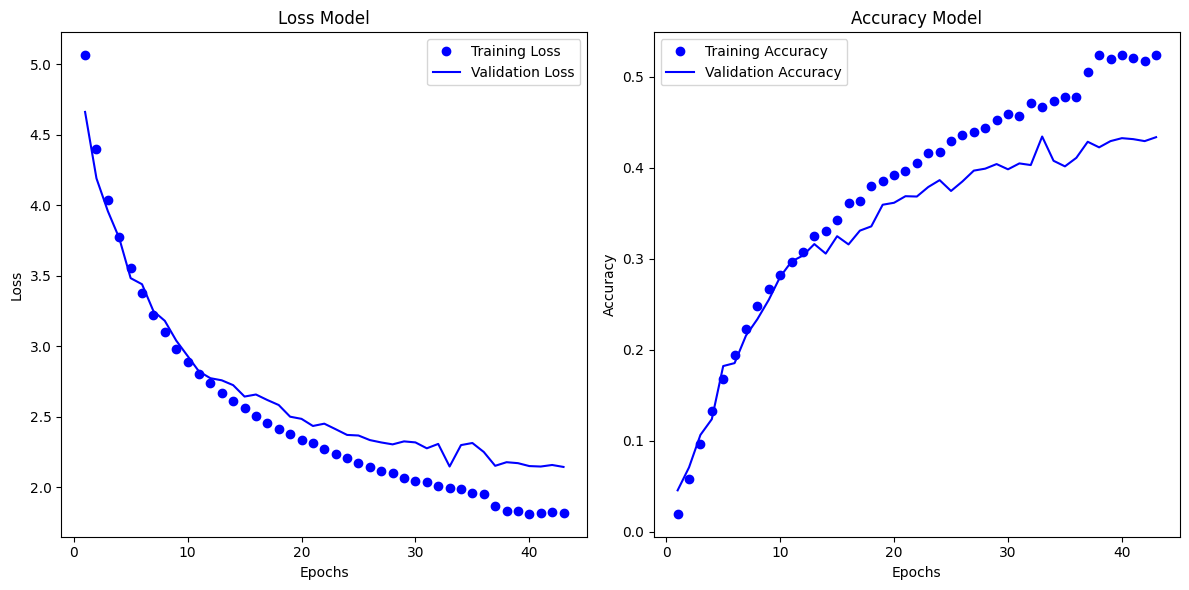

In [ ]:
dplot_graph(**selected_history)

In [ ]:
selected_history['epochs'] = len(history.epoch)

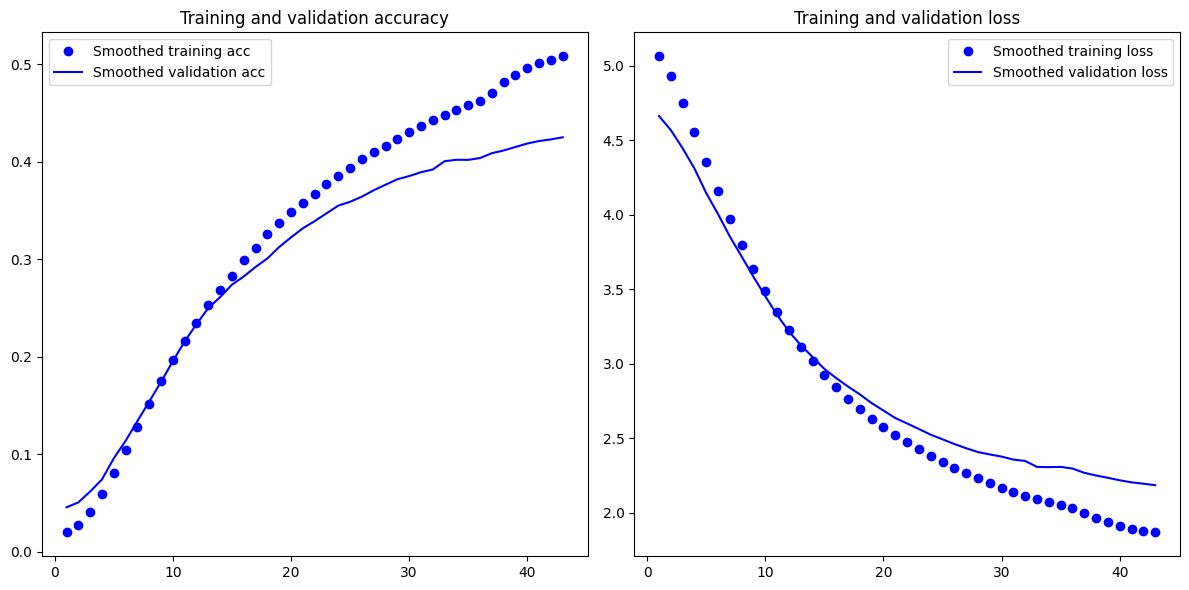

In [ ]:
dplot_smoothing(**selected_history)

# Evaluate model for testing

#### calculate number of steps

In [ ]:
steps = test_data_gen.n // test_data_gen.batch_size

In [ ]:
steps

120

# Evaluate

In [ ]:
test_loss, test_acc = model.evaluate(test_data_gen, steps=steps, verbose=0)

In [ ]:
test_acc

0.49270832538604736

#### Confusion Matrix

121/121 [==============================] - 16s 131ms/step


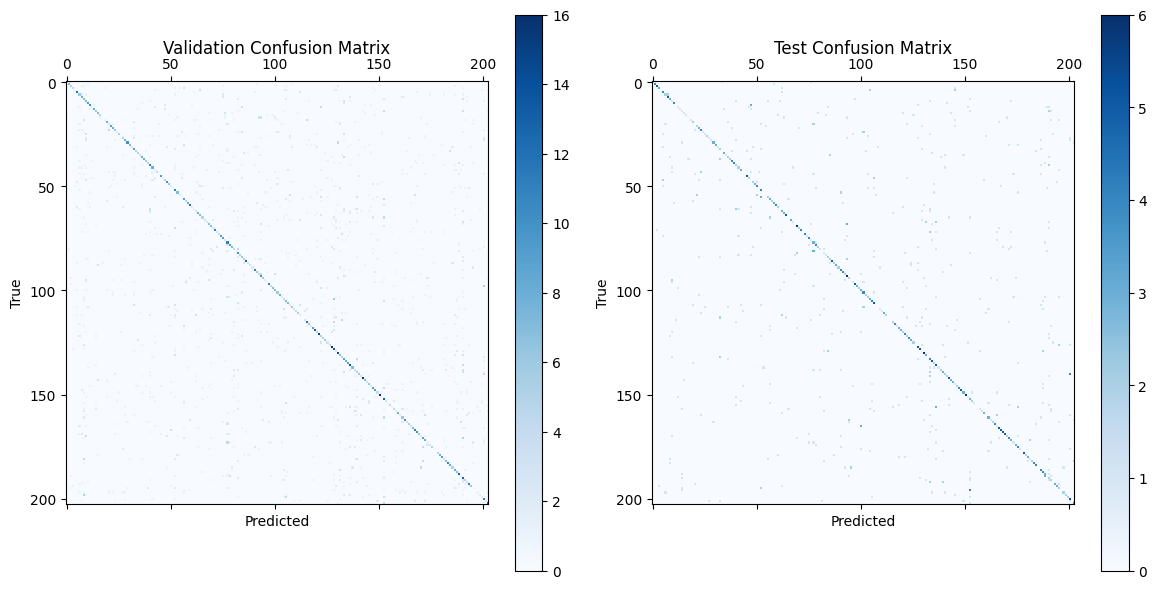

In [ ]:
dplot_confusion_matrix(model, val_data_gen, test_data_gen)

# Save model to file

In [ ]:
model_json = model.to_json()
with open('model_project.json', 'w') as json_file:
  json_file.write(model_json)

model.save_weights('model_project.h5')
print('Saved model to disk')

Saved model to disk


# Load model from file and prepare for testing

In [ ]:
input_shape = (MAX_HEIGHT, MAX_WIDTH, 1)
loaded_model = build_transfer_model(input_shape, len(selected_authors))

In [ ]:
loaded_model.load_weights('model_project.h5')

In [ ]:
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(test_data_gen)
print("%s: %.3f%%" % (loaded_model.metrics_names[1], score[1]*100))

121/121 [==============================] - 15s 121ms/step - loss: 0.0478 - accuracy: 0.4938
accuracy: 49.376%


# Run Test data

#### Predict

In [ ]:
predictions = loaded_model.predict(test_data_gen)
predicted_labels = np.argmax(predictions, axis=1)

121/121 [==============================] - 15s 121ms/step


#### Use Majority vote for final predictions

In [ ]:
author_to_final_preds, author_to_confidences = predict_using_majority_vote_by_author(loaded_model, test_data_gen)

121/121 [==============================] - 15s 121ms/step


#### Calculate average confidence

In [ ]:
average_confidence = sum(author_to_confidences.values()) / len(author_to_confidences)
print(f"Average Confidence: {average_confidence * 100:.2f}%")

Average Confidence: 56.96%


#### Analyze the predictions

In [ ]:
class_indices = test_data_gen.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

In [ ]:
correct_preds, incorrect_preds = categorize_predictions(author_to_final_preds, index_to_class)

#### Incorrect Predictions

In [ ]:
len(incorrect_preds)

64

#### Correct predictions

In [ ]:
len(correct_preds)

139